# Classification

**Classification from the business perspective of Mobile.de/Craigslist:**

In contrast to websites like Amazon that heavily curate their products, sites like Mobile.de are almost entirely user driven. Marketplaces trade-off their curation process, for a wide variety of offers and good prices. This lack of quality is apparent in the car adverts themselves, most noticable in their lack of consistency. This is very visible in the dataset itself: A lot of missing values, misplaced informatin, etc...

A classifier can be built on the provdided essential information in the advert and fill in optional fields. For example a classifier could determine the car type by looking at its features.

**Classification in the technical sense:**

Usually classifiers set a decision boundary on which the data is separated. For SVMs these can for example be hyper planes which mark a border in you vector space. For logistic regression it is a defined threshold. Most basic classifiers are bound by a linear boundary, this can be leveraged with the kernel trick. A kernel trick is a computationally feasible method to generate non-linear boundaries. It imitates the very computationally complex operation of translating the data into a higher dimensional space and laying a decision boundary there.


**Objective**

In this task we'll do a binary classification with Support Vector Machines (SVMs). Since we only used feature embedding for visual evaluation in the last task, this time we'll apply them on our Model and train with the lower dimensional representation of our dataset.
In the 'clustering' phase we got a look at features that might yield good classification results. Most notably pickups and hatchback in feature 'type' showed some promise in being seperable. We'll evaluate this visual assesment with the SVM model.

To get the best results we'll make use of grid search to get the best hyperparameters for this dataset.

## Agenda

- Visual data inspection & preparation
- Train SVM with Hyperparam tuning (Grid search)
- Evaluate Model(Confusion-Matrix, F-Score, ROC, etc...)

# Setup

In [ ]:
from google.colab import drive
import os

# skip, if not running on Google Colab
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
from plotly.offline import iplot
import plotly.graph_objs as go

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

pd.options.display.max_rows = 100 #default = 60
sns.set_theme(style="whitegrid")
pio.renderers.default = 'colab'

In [ ]:
# load pickle dataset into DataFrame
df = pd.read_pickle('df_std_no_outlier')
df.shape

(76133, 18)

## Create and Save t-SNE dataset

The t-SNE algorithm can take a long time to compute feature embedding. Since it's not uncommon for colab to crash during testing, these code blocks can be used to save a t-SNE dataframe and simply load it again after crashing. 

In [ ]:
# t-SNE function
def t_sne(df, components=3, rnd_state=3, r_seed=3, n_samples=2000):
  embedded_array = TSNE(n_components=components, learning_rate='auto', init='random', random_state=rnd_state).fit_transform(df.select_dtypes(include=np.number).sample(n=n_samples, random_state=r_seed))
  
  return embedded_array

In [ ]:
# Augment our embedded DF with features from our normal DF

def merge_df(embedded_array, augment_df, n=2000, r_seed=3):
  
  #convert np array to df
  if embedded_array.shape[1] == 3:
    embedded_df = pd.DataFrame({'x':embedded_array[:,0], 'y':embedded_array[:,1], 'z':embedded_array[:,2]})
  elif embedded_array.shape[1] == 2:
    embedded_df = pd.DataFrame({'x':embedded_array[:,0], 'y':embedded_array[:,1]})
  else:
    print('has to be 2D or 3D')

  # extract right sample from augment df to add to t-sne array
  df_sample = augment_df.sample(n=n, random_state=r_seed).reset_index()
  
  # join both dfs
  augmented_df = embedded_df.join(df_sample)
  return augmented_df

In [ ]:
# Option 1: Create large df
# Run this to code to have larger sample size 
# 15k --> t = approx 12.30min
# whole dataset --> t = approx 1:30h

# embedded = t_sne(df, n_samples=15000)
# embedded_df = merge_df(embedded, df, n=15000)
# embedded_df.to_pickle('embedded_df_15k_a')


## Option 2: Create small df (2k samples, 1:30min)
# alternatively run this:
# embedded = t_sne(df)
# embedded_df = merge_df(embedded, df)

# Visual inspection

In [ ]:
# load saved dataset
embedded_df = pd.read_pickle('embedded_df')
embedded_df_2d = pd.read_pickle('embedded_df_2d')

embedded_df

x          y          z  ...  state       lat      long
0     -23.126558  -5.843668 -18.542503  ...     al -0.922756  0.044555
1      22.065207  12.661352  -5.311594  ...     al -0.928864  0.046607
2     -24.583229  -5.880950 -19.097836  ...     al -0.917714  0.046866
3      19.257366  11.102495  -8.086612  ...     al -0.917486  0.049303
4       0.251195   9.509534  28.764879  ...     al -0.891134  0.034375
...          ...        ...        ...  ...    ...       ...       ...
76128  -2.292816  22.200668 -14.794304  ...     wy  0.567862 -0.976336
76129  17.044621  -8.430037 -12.176709  ...     wy  0.567862 -0.976336
76130   9.718032 -15.508439  10.122622  ...     wy  0.250943 -0.735767
76131  -2.488625 -23.660879   5.726279  ...     wy  0.593956 -0.874478
76132  20.947678  -8.657050 -41.753029  ...     wy  0.791525 -0.312297

[76133 rows x 22 columns]

In [ ]:
fig = px.scatter_3d(embedded_df, x='x', y='y', z='z', color='type') # <-- select features for color coding
fig.show()

In [ ]:
# 2D Plot
fig = px.scatter(embedded_df_2d, x='x', y='y', color='type') # <-- select features for color coding
fig.show()

As we can see type hatchback and pickup seem to be somewhat separated in their own data 'clouds'. Let's assess how easy it is classify either of these algorithmically and evaluate our results with statistic tools.

# Preparation

Since we'll only work with hatchbacks and pickups we can discard the rest of our data

In [ ]:
options = ['hatchback', 'pickup']

df_type = embedded_df[embedded_df['type'].isin(options)] 
df_type_2d = embedded_df_2d[embedded_df_2d['type'].isin(options)] 
df_type_2d

x           y   index  ... state       lat      long
1       63.487782  -26.367245      55  ...    al -0.928864  0.046607
39       6.884309 -109.628510     370  ...    al -0.818197 -0.010004
48     -41.910488  -58.169617     416  ...    al -0.833399 -0.008007
55    -110.574905   42.447548     441  ...    al -0.809280 -0.006764
61      49.488441  -58.633251     484  ...    al -0.833416 -0.008002
...           ...         ...     ...  ...   ...       ...       ...
76096    1.135137   31.469240  426676  ...    wy  0.698906 -0.883680
76098   66.430374   86.435493  426715  ...    wy  0.699598 -0.683811
76099   22.678019  -61.658329  426719  ...    wy  0.750689 -0.823549
76126  -81.753525   43.424381  426792  ...    wy  0.250200 -0.735305
76130   -9.712963   -8.829852  426831  ...    wy  0.250943 -0.735767

[9240 rows x 21 columns]

In [ ]:
print(df_type['type'].value_counts())
print()
print(df_type_2d['type'].value_counts())

pickup       6202
hatchback    3038
Name: type, dtype: int64

pickup       6202
hatchback    3038
Name: type, dtype: int64


Pickups seem to be overrepresented in this dataset by a scale of 2:1.
We would need to whether this imbalance has any impact on model performance.
To counteract imbalanced data we have 2 options:

**Oversampling**:
Duplicate the underrepresented data to match the instances of the other label. This removes the imbalance, but the underrepresented data still lacks variety.

**Undersampling**:
Remove instances of the overrepresented data to match the underrepresented label. This means that there will be fewer training data to train the model, but balance between label is established

In [ ]:
# Extract model relevant data
y_nom = df_type['type']
# encode label
le = LabelEncoder()
y = le.fit_transform(y_nom)
print(np.unique(y,return_counts=True))  # Value 0 are hatchbacks, value 1 are pickups

# Split data
X = df_type[['x', 'y', 'z']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

(array([0, 1]), array([3038, 6202]))


In [ ]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([0, 1]), array([2065, 4125]))
(array([0, 1]), array([ 973, 2077]))


# Model

## SVM

Suppert Vector Machines are the evolution of the first Machine Learning Algorithm: [The Perceptron](https://web.mit.edu/course/other/i2course/www/vision_and_learning/perceptron_notes.pdf). 

The Perceptron Algorithm lays a n-1 dimensional decision boundary in a vector space that tries to solve a binary classification problem. Given a dataset that is linearly seperatble, the Perceptron is bound to converge in a limited amount of iterations. There are two problems that arise with the Perceptron though:

1. The Perceptron Algorithm is guaranteed set a decision boundary, but the location of the decision boundary is dependant on the dataset and the initialization. This means that based on the starting point a decision boundary might be drawn that separates all training examples, but borders very close to one label, such that it is bound to misclassify with test samples.

2. This Algorithm only works on linearly seperable classification tasks, which is a rarity in real world examples, like for example our car dataset. The perceptron will mindlessly iterate through all datapoints without ever converging.

SVM resolves these limitations by introducing a Loss function, which strives to maximize a margin boundary around the decision boundary. During the training the Loss function scrutinizes decision boundaries for points that are inside the margin boundary, with the goal of finding the decision boundary with the lowest loss value. The margin boundary is a hyperparameter that can be adjusted to find the optimal decision boundary. This for example can be done with gradient descent. The base SVM is constructed to solve classification problems with a linear decision boundary. By using **kernels** SVMs are also capable of laying non-linear decision boundaries. The data gets projected onto a higher dimensional space where the original data is now linearly separable. From the perspective of the original dimension the separator now has a non-linear form. The boundary from a RBF Kernel for example has a round shape when observed from the original dimensionality. In reality the kernel trick is used, which is only a representation of a higher dimensional projection, since these are computationally very expensive to calculate. 

Since there are a lot of different kernels it can technically be seen as another hyperparameter of the SVM.

The most important parameter for finding the optimal decision boundary is **C** and **Gamma**. C regulates the bias/variance trade-off while training. A high value of C prioritizes right classification over a high margin within the margin boundary, which might be prone to overfit. The other way around a lower C value prioritizes a high margin between the 2 labels over the occasional misclassification. Gamma defines the margin boundary of the Support Vector Classifiert. The Margin is the scope on which C tries to find the optimal decision boundary. A high gamma value sets a narrow margin, while a low gamma value sets a wide margin.

Methods like Grid Search can be used to find the optimal value of more than one hyperparameter. In case of the SVM a grid search can be used to find a good decision boundary by training with different gamma and C values, which then can be repeated for different kernels. The parameters of the best model will then be chosen.

## Baseline model

First, we'll apply a simple model to figure out how the SVM implementation in scikit-learn works, as well as to define a baseline model on which to measure other models.

Our baseline model will be the standard linear SVM. 
- ...the default regularization parameter of 1...
- ...and default gamma  set to scale 'scale' which is calculated as follows: 1 / (n_features * X.var()) ==> [0.001050, 0.001216, 0.001084]

In [ ]:
# get gamma
gamma = 1/(X.shape[1]*X.var())
gamma

x    0.001050
y    0.001216
z    0.001084
dtype: float32

In [ ]:
svc = SVC(kernel='linear', gamma='scale')
svc_model = svc.fit(X_train, y_train)

y_pred = svc_model.predict(X_test)

#... sadly sklearn doesn't allow us to use a custom gamma value. We chose between 2 options only: 'scale' and 'auto'

## Evaluierung

**A look at our Model**

- Support vectors: These are the datapoints that mark the margin boundary

In [ ]:
# support vectors
svc_model.support_vectors_

array([[-16.29227638,   4.89857197,  21.85492897],
       [ -4.84357452, -29.88596916,  -0.80651313],
       [-14.38660336,  13.76849651,  27.85582542],
       ...,
       [-24.78502464,   4.38471079,   8.22355461],
       [ 14.18414211, -32.88323212,  -3.36874008],
       [ 26.034338  , -10.09396744, -10.34671783]])

**3D Plot**


In [ ]:
# 3D Plot

# extract support vectors

svc_model.coef_

array([[-0.0144459 ,  0.02431138, -0.06407691]])

In [ ]:
# z = lambda x,y: (-svc_model.intercept_[0]-svc_model.coef_[0][0]*x -svc_model.coef_[0][1]*y) / svc_model.coef_[0][2]

# tmp = np.linspace(-5,5,30)
# x_1 ,y_1 = np.meshgrid(tmp,tmp)

# fig = plt.figure()
# ax  = fig.add_subplot(111, projection='3d')
# ax.plot3D(X[y==0,0], X[y==0,1], X[y==0,2],'ob')
# ax.plot3D(X[y==1,0], X[y==1,1], X[y==1,2],'sr')
# ax.plot_surface(x_1, y_1, z(x_1,y_1))
# ax.view_init(30, 60)
# plt.show()

In [ ]:
df_type_sample = df_type.sample(n=100)

fig = px.scatter_3d(df_type_sample, x='x', y='y', z='z', color='type')

light_yellow = [[0, '#FFDB58'], [1, '#FFDB58']]

zero_pt = pd.Series([0])
z = zero_pt.append(df_type_sample['z'], ignore_index = True).reset_index(drop = True)
y = zero_pt.append(df_type_sample['y'], ignore_index = True).reset_index(drop = True)
x = zero_pt.append(df_type_sample['x'], ignore_index = True).reset_index(drop = True)

print(x.shape)

length_data = len(z)
z_plane_pos = 0*np.ones((length_data,length_data))

fig.add_trace(go.Surface(x=x, y=y, z=z_plane_pos, colorscale=light_yellow,  showscale=False))
fig.show()

(101,)


**Confusion Matrix**

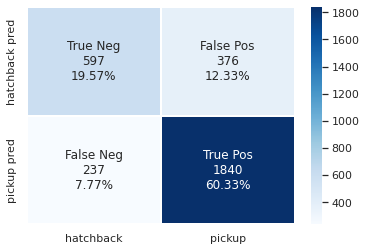

In [ ]:
# Confusion Matrix

cat_x = ['hatchback', 'pickup']
cat_y = ['hatchback pred', 'pickup pred']

c_matrix = confusion_matrix(y_test, y_pred,)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten()/np.sum(c_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues', linewidths=1, xticklabels=cat_x, yticklabels=cat_y)

**Sensitivity & Specificity**

In [ ]:
# Sensitivity & Specificity

def sens_spec(cm):

  tn, fp, fn, tp = cm.ravel()
  #sensitivity
  sens = tp / (tp+fn)
  #specificity
  spec = tn / (tn+fp)

  print("sensitivity:\t{}\nspecificity:\t{}".format(sens, spec))

sens_spec(c_matrix)

sensitivity:	0.8858931150698123
specificity:	0.6135662898252826


**Precision, Recall, f1-Score, Support**

In [ ]:

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       973
           1       0.83      0.89      0.86      2077

    accuracy                           0.80      3050
   macro avg       0.77      0.75      0.76      3050
weighted avg       0.79      0.80      0.79      3050



## Hyperparam tuning with Grid Search

In [ ]:
# reset SVC with default values
svc = SVC()

# define grid

# let's try out linear and logarithmic spacing!
n = 3
lin = np.linspace(0.01, 10, num=n)
log = np.geomspace(0.1, 1, num=n)
print('linear spacing:\t\t', np.round(lin, 2))
print('logarithmic spacing:\t', np.round(log, 2))

param_grid = {
    #'C' : lin
    'kernel' : ['rbf', 'poly'] #['linear', 'poly', 'rbf', 'sigmoid'],
    #'gamma' : ['scale', 'auto']
}


# instantiate Grid Search object
gs = GridSearchCV(estimator=svc, param_grid=param_grid)
gs_results = gs.fit(X_train, y_train)

linear spacing:		 [ 0.01  5.   10.  ]
logarithmic spacing:	 [0.1  0.32 1.  ]


In [ ]:
results_df = pd.DataFrame(gs_results.cv_results_)
results_df

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       0.678625      0.129139  ...        0.004916                1
1       0.888754      0.040920  ...        0.002043                2

[2 rows x 14 columns]

# Evaluation

# Conclusion